# Matching times of tokens and corresponding measures

A common task is to extract acoustic and other measurements from a time series analysis that correspond to labelled tokens (e.g. phones, clusters, words, phrases, contexts) in an annotation file. This notebook illustrates how to perform this task with the function `match_tokentimes`.

In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from audiolabel import read_label
from phonlab.utils import match_tokentimes

## Example data

Let's start with a spectrogram, which consists of a series of spectral slices calculated at regular timesteps, with each slice consisting of a number of frequency bins. Each datapoint in the spectrogram is the magnitude of a frequency bin in its spectral slice.

Spectral analysis typically results in a 2d array in which the times of the spectral slices (of which there are 200 here) are along the rows (axis 0), and the frequencies (of which there are 100 here) are along the columns (axis 1). For `imshow` we flip the axes with `.T` (an alias of `transpose()`) so that time is on the x-axis (columns) and frequencies are on the y-axis (rows) in the spectrogram image.

The axis labels show the integer index of the values in each dimension, which range from 0&ndash;199 for times and 0&ndash;99 for frequencies. **These indexes are not the times and frequencies themselves; they are simply the locations of the spectral slices/frequencies in the ordered axis.**

Spectrogram shape: (200, 100)


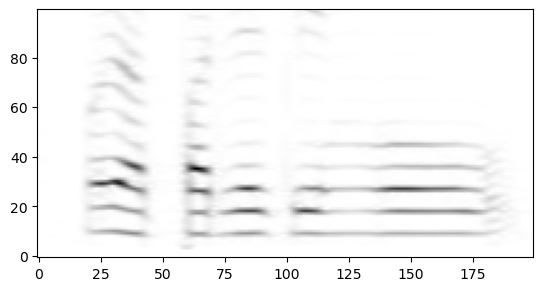

In [2]:
d = np.load('../resource/spectrogram/spec.npz')
spec = d['spec']
print(f'Spectrogram shape: {spec.shape}')
plt.imshow(spec.T, origin='lower', cmap='gray_r')

Individual spectral slices can be selected by indexing `spec` to return a specific row. The resulting plot shows the frequency bins on the x-axis and their magnitudes on the y-axis. The location of the maximum value is indicated by the red vertical line.

Index of max freq in spectral slice 26: 29


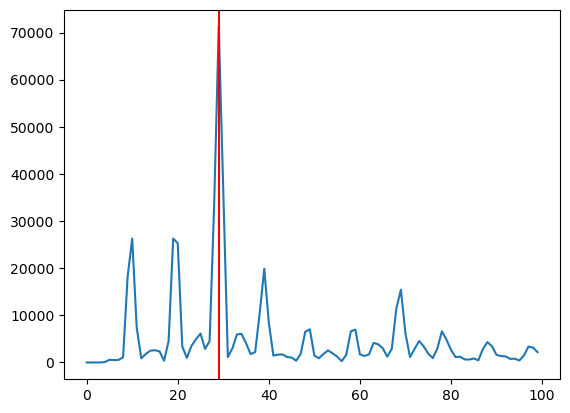

In [3]:
specidx = 26  # index of spectral slice to plot, any integer from 0 to 199
specslice = spec[specidx,:]
idxmax = np.argmax(specslice)
print(f'Index of max freq in spectral slice {specidx}: {idxmax}')
plt.plot(specslice.T)
plt.axvline(x=idxmax, color='r')

A spectral analysis will also include 1d arrays that list the times of the spectral slices and the frequency bins that are the same length as the corresponding axes of `spec`. `spectimes` has a time value (seconds) for every spectral slice of `spec`, and `freqs` has a frequency value (Hz) for every frequency bin of spec. The lengths of these arrays match the lengths of the axes of `spec`.

In [4]:
spectimes = d['spectimes']
freqs = d['freqs']
print(f'Shape of spec: {spec.shape}.\nLength of spectimes: {len(spectimes)}.\nLength of freqs: {len(freqs)}.')
print(f'\nspectimes values {spectimes}')
print(f'\nfreqs values {freqs}')

Shape of spec: (200, 100).
Length of spectimes: 200.
Length of freqs: 100.

spectimes values [0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83
 0.85 0.87 0.89 0.91 0.93 0.95 0.97 0.99 1.01 1.03 1.05 1.07 1.09 1.11
 1.13 1.15 1.17 1.19 1.21 1.23 1.25 1.27 1.29 1.31 1.33 1.35 1.37 1.39
 1.41 1.43 1.45 1.47 1.49 1.51 1.53 1.55 1.57 1.59 1.61 1.63 1.65 1.67
 1.69 1.71 1.73 1.75 1.77 1.79 1.81 1.83 1.85 1.87 1.89 1.91 1.93 1.95
 1.97 1.99 2.01 2.03 2.05 2.07 2.09 2.11 2.13 2.15 2.17 2.19 2.21 2.23
 2.25 2.27 2.29 2.31 2.33 2.35 2.37 2.39 2.41 2.43 2.45 2.47 2.49 2.51
 2.53 2.55 2.57 2.59 2.61 2.63 2.65 2.67 2.69 2.71 2.73 2.75 2.77 2.79
 2.81 2.83 2.85 2.87 2.89 2.91 2.93 2.95 2.97 2.99 3.01 3.03 3.05 3.07
 3.09 3.11 3.13 3.15 3.17 3.19 3.21 3.23 3.25 3.27 3.29 3.31 3.33 3.35
 3.37 3.39 3.41 3.43 3.45 3.47 3.49 3.51 3.53 3.55 3.57

We can use `spectimes` and `freqs` to redefine the axes labels displayed by `imshow`. The first two values of the `extent` parameter define the first and last values of the x-axis, and other two values define the first and last values of the y-axis, i.e. they are the first and last times followed by the first and last frequencies.

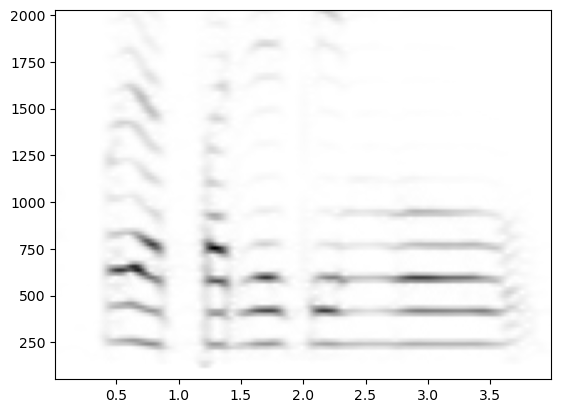

In [5]:
plt.imshow(
    spec.T,
    origin='lower',
    cmap='gray_r',
    extent=[spectimes[0], spectimes[-1], freqs[0], freqs[-1]],
    aspect=0.0015
)

## Token annotations

Now consider a set of annotations of the audio file that was used to generate the spectrogram. You can load these into a dataframe and correlate them with spectral slices. The start and end times of each annotation are in the `t1` and `t2` columns, and the `label` column contains the content. In the second step the midpoint of each annotation is calculcated and added as the `midpt` column.

In [6]:
[tg] = read_label('../resource/spectrogram/spec.tg', ftype='praat')
tg['midpt'] = (tg['t1'] + tg['t2']) / 2
tg

,t1,t2,label,fname,midpt
0,0.000,0.349,,../resource/spectrogram/spec.tg,0.1745
1,0.349,0.919,V,../resource/spectrogram/spec.tg,0.6340
2,0.919,1.122,t,../resource/spectrogram/spec.tg,1.0205
3,1.122,1.378,n,../resource/spectrogram/spec.tg,1.2500
4,1.378,1.577,d,../resource/spectrogram/spec.tg,1.4775
5,1.577,1.878,V,../resource/spectrogram/spec.tg,1.7275
6,1.878,1.982,,../resource/spectrogram/spec.tg,1.9300
7,1.982,3.750,V,../resource/spectrogram/spec.tg,2.8660
8,3.750,3.970,,../resource/spectrogram/spec.tg,3.8600


From these annotations you can select the rows that are the tokens you are interested in processing. Here are all the 'V' tokens.

In [7]:
tok = tg[tg['label'] == 'V']
tok

,t1,t2,label,fname,midpt
1,0.349,0.919,V,../resource/spectrogram/spec.tg,0.6340
5,1.577,1.878,V,../resource/spectrogram/spec.tg,1.7275
7,1.982,3.750,V,../resource/spectrogram/spec.tg,2.8660


## Matching times



The next step is to select spectral slices from the spectrogram that correspond to the token times. One way to do this is to find the spectral slice closest to the midpoint of the token. The `match_tokentimes` function compares two time arrays. For every value of the first array the index of the closest match in the second array is returned. In this example, the indexes of the spectral slices that most closely match the token midpoints are the result stored in `tidx`.

In [8]:
tidx = match_tokentimes(tok['midpt'], spectimes)
tidx

array([ 31,  86, 143])

If you use `tidx` to select the times of the spectral slices from `spectimes`, you find values that are close to the midpoints found in the `midpt` column of `tok`.

In [9]:
spectimes[tidx]

array([0.63, 1.73, 2.87])

To select the spectral slices, use `tidx` on `spec`. The result is three rows of 100 frequency bins, one row per token.

In [10]:
spec[tidx].shape

(3, 100)

### Multiple measures per token

In many cases you will want to find measures at multiple times per token, for example at the beginning of the token, 25% of the way through the token, 50%, 75%, and at the end. To do this, first use [`linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) to create five equally-spaced values from the start of each token to the end.
The return value is a 2d array that has a row for each token, and the times are arranged in the columns. The `axis=1` parameter ensures that `linspace` returns the times in the correct shape.

In [11]:
toktimes = np.linspace(tok['t1'], tok['t2'], num=5, axis=1)
toktimes

array([[0.349  , 0.4915 , 0.634  , 0.7765 , 0.919  ],
       [1.577  , 1.65225, 1.7275 , 1.80275, 1.878  ],
       [1.982  , 2.424  , 2.866  , 3.308  , 3.75   ]])

The `match_tokentimes` function accepts a 2d first parameter, where the tokens are arranged along the first axis, as they are in `toktimes`.

In [12]:
tidx = match_tokentimes(toktimes, spectimes)

The `tidx` array is in the same shape as `toktimes`, which means you can access the data for each token from its index location. The first token is at index 0.

In [13]:
first_token = tidx[0]
first_token

array([17, 24, 31, 38, 45])

Use the indexes in `first_token` to select spectrogram data from `spec` and times from `spectimes`.

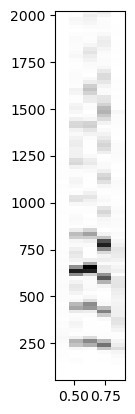

In [14]:
plt.imshow(
    spec[first_token].T,
    origin='lower',
    cmap='gray_r',
    extent=[spectimes[first_token][0], spectimes[first_token][-1], freqs[0], freqs[-1]],
    aspect=0.0015
)

### Reshaping tokens

When you use a 2d `tidx` to select from 2d data such as a spectrogram, the result is a 3d array. The first axis represents the tokens, and the other axes represent the axes of the spectrogram, which are the times of the spectral slices and the frequency bins. Here we have 3 tokens consisting of 5 spectral slices and 100 frequencies.

In [15]:
spec[tidx].shape

(3, 5, 100)

To reshape your data into a 2d array by token, use [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). Use the number of tokens as the first parameter and `-1` as the second. These settings instruct `reshape` to keep the token axis as it is and to collapse the remaining dimensions into a 1d array.

Use this reshaping technique whenever you need to use a function that expects a 2d array of `m` tokens and `n` features.

In [16]:
spectokens = spec[tidx].reshape(len(toktimes), -1)
spectokens.shape

(3, 500)